In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.integrate import cumtrapz
from scipy.stats import gaussian_kde
import scipy.stats as stats
from getdist import plots, MCSamples
import matplotlib as mpl
from astropy.cosmology import Planck15
from scipy.interpolate import InterpolatedUnivariateSpline
import fsps
import emcee
from scipy.special import hyp2f1
from affine import *

import tensorflow as tf
import tensorflow_probability as tfp
import tqdm
from tqdm import trange
tfb = tfp.bijectors
tfd = tfp.distributions
tfkl = tf.keras.layers
tfpl = tfp.layers
tfk = tf.keras

/Users/justinalsing/.pyenv/versions/3.8.6/envs/base3.8/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Import training data for stellar mass emulator

In [2]:
# prior samples
n_samples = 10000
z = np.random.uniform(0, 2.5, n_samples)
tuniv = Planck15.age(z).value
alpha = 10**(np.random.uniform(-1, 3, n_samples))
beta = 10**(np.random.uniform(-1, 3, n_samples))
tau = np.random.uniform(0.1, tuniv)

# SPS model
sp = fsps.StellarPopulation(zcontinuous=3, compute_vega_mags=False, sfh=3)
sp.params['logzsol'] = 0.

# compute the stellar masses
stellar_mass = np.zeros(n_samples)
for i in trange(n_samples):
    
    # time grid
    nt = 10000
    t = np.concatenate([tuniv[i] * (1. - np.logspace(-3, -1e-10, nt))[::-1], np.array([tuniv[i]])])

    # SFH
    logsfr = -np.log((t/tau[i])**alpha[i] + (tau[i]/t)**beta[i])
    logsfr = logsfr - max(logsfr)
    sfr = np.exp(logsfr)
    sfr = sfr/np.trapz(x=t, y=sfr)
    
    # ZH
    Z = 0.0142 # Solar
    zt = np.concatenate([np.array([0.]), cumtrapz(x=t, y=sfr)])
    zt = zt * Z / zt[-1]
    
    # SFH -> stellar-mass
    sp.set_tabular_sfh(t, sfr*1e-9, Z=zt)
    stellar_mass[i] = sp.stellar_mass[-1]

  0%|          | 1/10000 [02:30<417:28:21, 150.31s/it]<ipython-input-2-d43335904c7b>:22: RuntimeWarning: overflow encountered in power
  logsfr = -np.log((t/tau[i])**alpha[i] + (tau[i]/t)**beta[i])
100%|██████████| 10000/10000 [15:18<00:00, 10.89it/s] 


Train emulator for stellar mass fraciton

In [3]:
inputs = tf.convert_to_tensor(np.column_stack([np.log10(alpha), np.log10(beta), tau, z]), dtype=tf.float32)
outputs = tf.convert_to_tensor(stellar_mass, dtype=tf.float32)

stellar_mass_emulator = tfk.Sequential()
stellar_mass_emulator.add(tfkl.Dense(32, input_shape=(4,), activation=tf.nn.tanh, kernel_initializer=tfk.initializers.RandomNormal(stddev=1e-5)))
stellar_mass_emulator.add(tfkl.Dense(1, activation=tf.nn.sigmoid))
stellar_mass_emulator.compile(optimizer=tfk.optimizers.Adam(lr=0.01), loss='mse')

stellar_mass_emulator.fit(inputs, outputs, batch_size=2048, epochs=300)

Epoch 1/300
5/5 [==============================] - 0s 754us/step - loss: 0.0044
Epoch 2/300
5/5 [==============================] - 0s 685us/step - loss: 0.0016
Epoch 3/300
5/5 [==============================] - 0s 662us/step - loss: 8.3605e-04
Epoch 4/300
5/5 [==============================] - 0s 845us/step - loss: 3.6614e-04
Epoch 5/300
5/5 [==============================] - 0s 955us/step - loss: 2.3417e-04
Epoch 6/300
5/5 [==============================] - 0s 786us/step - loss: 2.3904e-04
Epoch 7/300
5/5 [==============================] - 0s 818us/step - loss: 1.8046e-04
Epoch 8/300
5/5 [==============================] - 0s 788us/step - loss: 9.8036e-05
Epoch 9/300
5/5 [==============================] - 0s 755us/step - loss: 7.3718e-05
Epoch 10/300
5/5 [==============================] - 0s 793us/step - loss: 6.4753e-05
Epoch 11/300
5/5 [==============================] - 0s 1ms/step - loss: 4.8532e-05
Epoch 12/300
5/5 [==============================] - 0s 743us/step - loss: 3.2199e-05

5/5 [==============================] - 0s 711us/step - loss: 2.1225e-06
Epoch 98/300
5/5 [==============================] - 0s 654us/step - loss: 2.1314e-06
Epoch 99/300
5/5 [==============================] - 0s 704us/step - loss: 2.1406e-06
Epoch 100/300
5/5 [==============================] - 0s 681us/step - loss: 2.0485e-06
Epoch 101/300
5/5 [==============================] - 0s 741us/step - loss: 2.1328e-06
Epoch 102/300
5/5 [==============================] - 0s 676us/step - loss: 2.1302e-06
Epoch 103/300
5/5 [==============================] - 0s 705us/step - loss: 2.0535e-06
Epoch 104/300
5/5 [==============================] - 0s 702us/step - loss: 2.1737e-06
Epoch 105/300
5/5 [==============================] - 0s 676us/step - loss: 2.1062e-06
Epoch 106/300
5/5 [==============================] - 0s 680us/step - loss: 2.1495e-06
Epoch 107/300
5/5 [==============================] - 0s 786us/step - loss: 2.1356e-06
Epoch 108/300
5/5 [==============================] - 0s 701us/step - l

5/5 [==============================] - 0s 667us/step - loss: 2.1138e-06
Epoch 193/300
5/5 [==============================] - 0s 695us/step - loss: 2.0775e-06
Epoch 194/300
5/5 [==============================] - 0s 650us/step - loss: 2.0231e-06
Epoch 195/300
5/5 [==============================] - 0s 777us/step - loss: 2.1579e-06
Epoch 196/300
5/5 [==============================] - 0s 682us/step - loss: 2.0738e-06
Epoch 197/300
5/5 [==============================] - 0s 724us/step - loss: 2.1617e-06
Epoch 198/300
5/5 [==============================] - 0s 775us/step - loss: 2.0688e-06
Epoch 199/300
5/5 [==============================] - 0s 709us/step - loss: 2.0306e-06
Epoch 200/300
5/5 [==============================] - 0s 667us/step - loss: 2.0773e-06
Epoch 201/300
5/5 [==============================] - 0s 687us/step - loss: 2.1030e-06
Epoch 202/300
5/5 [==============================] - 0s 756us/step - loss: 2.0426e-06
Epoch 203/300
5/5 [==============================] - 0s 703us/step -

5/5 [==============================] - 0s 685us/step - loss: 2.1234e-06
Epoch 288/300
5/5 [==============================] - 0s 675us/step - loss: 2.0906e-06
Epoch 289/300
5/5 [==============================] - 0s 775us/step - loss: 2.1599e-06
Epoch 290/300
5/5 [==============================] - 0s 670us/step - loss: 2.0792e-06
Epoch 291/300
5/5 [==============================] - 0s 742us/step - loss: 2.0950e-06
Epoch 292/300
5/5 [==============================] - 0s 745us/step - loss: 2.1526e-06
Epoch 293/300
5/5 [==============================] - 0s 717us/step - loss: 2.0904e-06
Epoch 294/300
5/5 [==============================] - 0s 722us/step - loss: 2.1808e-06
Epoch 295/300
5/5 [==============================] - 0s 780us/step - loss: 2.1340e-06
Epoch 296/300
5/5 [==============================] - 0s 708us/step - loss: 2.1783e-06
Epoch 297/300
5/5 [==============================] - 0s 699us/step - loss: 2.0988e-06
Epoch 298/300
5/5 [==============================] - 0s 715us/step -

Interpolator for tage

In [4]:
z = np.linspace(0, 2.5, 1000)
tuniv = Planck15.age(z).value
tuniv_interpolator = InterpolatedUnivariateSpline(z, tuniv)

Create training set for normalizing flow

<ipython-input-5-de9f1699defb>:2: RuntimeWarning: overflow encountered in power
  compute_log10sSFR = lambda alpha, beta, tau, z, tuniv: -np.log10((tuniv/tau)**alpha + (tau/tuniv)**beta) - np.log10((1./(beta+1.)) * tuniv*(tuniv/tau)**beta * hyp2f1(1., (beta+1.)/(alpha+beta), (beta+1.)/(alpha+beta) + 1., -(tuniv/tau)**(alpha+beta))) - 9. - np.log10(tf.squeeze(stellar_mass_emulator(tf.convert_to_tensor(np.column_stack([np.log10(alpha), np.log10(beta), tau, z]), dtype=tf.float32))).numpy())
<ipython-input-5-de9f1699defb>:2: RuntimeWarning: invalid value encountered in multiply
  compute_log10sSFR = lambda alpha, beta, tau, z, tuniv: -np.log10((tuniv/tau)**alpha + (tau/tuniv)**beta) - np.log10((1./(beta+1.)) * tuniv*(tuniv/tau)**beta * hyp2f1(1., (beta+1.)/(alpha+beta), (beta+1.)/(alpha+beta) + 1., -(tuniv/tau)**(alpha+beta))) - 9. - np.log10(tf.squeeze(stellar_mass_emulator(tf.convert_to_tensor(np.column_stack([np.log10(alpha), np.log10(beta), tau, z]), dtype=tf.float32))).numpy())
<ipyth

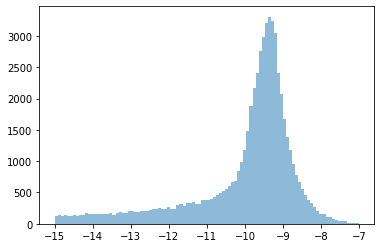

In [5]:
# computaiton of log10sSFR
compute_log10sSFR = lambda alpha, beta, tau, z, tuniv: -np.log10((tuniv/tau)**alpha + (tau/tuniv)**beta) - np.log10((1./(beta+1.)) * tuniv*(tuniv/tau)**beta * hyp2f1(1., (beta+1.)/(alpha+beta), (beta+1.)/(alpha+beta) + 1., -(tuniv/tau)**(alpha+beta))) - 9. - np.log10(tf.squeeze(stellar_mass_emulator(tf.convert_to_tensor(np.column_stack([np.log10(alpha), np.log10(beta), tau, z]), dtype=tf.float32))).numpy())

# prior samples
n_samples = 100000
z = np.random.uniform(0, 2.5, n_samples)
tuniv = tuniv_interpolator(z)
alpha = 10**(np.random.uniform(-1, 3, n_samples))
beta = 10**(np.random.uniform(-1, 3, n_samples))
tau = np.random.uniform(0.1, tuniv)

# log10sSFRs
log10sSFR = compute_log10sSFR(alpha, beta, tau, z, tuniv)

# cut and tensorize
cut = (log10sSFR > -15) * (log10sSFR < -7)
log10sSFR_training = tf.convert_to_tensor(log10sSFR[cut], dtype=tf.float32)
z_training = tf.convert_to_tensor(z[cut], dtype=tf.float32)[..., tf.newaxis]

# plot them
plt.hist(log10sSFR[cut], bins=100, alpha = 0.5)
plt.show()

Neural spline flow (1D)

In [6]:
class NeuralSplineFlow1D(tf.Module):
    
    def __init__(self, n_spline_bins=32, n_conditional=1, n_hidden=[10, 10], activation=tf.tanh, base_loc=0., base_scale=0.25, spline_min=-1., spline_range=2.):
        
        # spline bins
        self._n_spline_bins = n_spline_bins
        
        # conditional dimensions
        self._n_conditional = n_conditional
        
        # hidden units and activation function
        self._architecture = [n_conditional] + n_hidden
        self._activation = activation
        
        # loc and scale for the (normal) base density, spline set-up
        self._base_loc = base_loc
        self._base_scale = base_scale
        self._spline_min = spline_min
        self._spline_range = spline_range
        
        # networks parameterizing bin widths, heights and knot slopes
        self._bin_widths = tfk.Sequential([tfkl.Dense(self._architecture[i+1], activation=self._activation) for i in range(len(n_hidden))] + [tfkl.Dense(self._n_spline_bins)] + [tfkl.Lambda(lambda x: tf.math.softmax(x, axis=-1) * (self._spline_range - self._n_spline_bins * 1e-2) + 1e-2)])
        self._bin_heights = tfk.Sequential([tfkl.Dense(self._architecture[i+1], activation=self._activation) for i in range(len(n_hidden))] + [tfkl.Dense(self._n_spline_bins)] + [tfkl.Lambda(lambda x: tf.math.softmax(x, axis=-1) * (self._spline_range - self._n_spline_bins * 1e-2) + 1e-2)])
        self._knot_slopes = tfk.Sequential([tfkl.Dense(self._architecture[i+1], activation=self._activation) for i in range(len(n_hidden))] + [tfkl.Dense(self._n_spline_bins - 1)] + [tfkl.Lambda(lambda x: tf.math.softplus(x) + 1e-2)])

    # construct spline bijector given inputs x
    def spline(self, x):
   
        return tfb.RationalQuadraticSpline(
            bin_widths=self._bin_widths(x),
            bin_heights=self._bin_heights(x),
            knot_slopes=self._knot_slopes(x),
            range_min=self._spline_min)

    # construct transformed distribution given conditional inputs x
    def __call__(self, x):
        
        return tfd.TransformedDistribution(tfd.Normal(loc=self._base_loc, scale=self._base_scale), bijector=self.spline(x))
    
    # log probability for inputs y and conditionals x, ie., P(y | x)
    #@tf.function
    def log_prob(self, y, x):
        
        # construct spline
        rqspline = tfb.RationalQuadraticSpline(
            bin_widths=self._bin_widths(x),
            bin_heights=self._bin_heights(x),
            knot_slopes=self._knot_slopes(x),
            range_min=self._spline_min)
        
        # construct distribution
        distribution = tfd.TransformedDistribution(tfd.Normal(loc=self._base_loc, scale=self._base_scale), bijector=rqspline)
        
        return distribution.log_prob(y)

Train the neural spline flow

In [7]:
optimizer = tf.keras.optimizers.Adam(lr=1e-2)
epochs = 1000

NSF = NeuralSplineFlow1D(n_spline_bins=16, n_conditional=1, n_hidden=[16], spline_min=-15., spline_range=9., base_loc=-11., base_scale=1.)

with trange(epochs) as t:
    for epoch in t:
        with tf.GradientTape() as tape:
            logprob = -tf.math.reduce_sum(NSF.log_prob(log10sSFR_training, z_training))
        graients = tape.gradient(logprob, NSF.trainable_variables)
        optimizer.apply_gradients(zip(graients, NSF.trainable_variables))
        t.set_postfix(loss=logprob.numpy())

100%|██████████| 1000/1000 [01:56<00:00,  8.55it/s, loss=7.97e+4]


Plot the trained normalizing flow

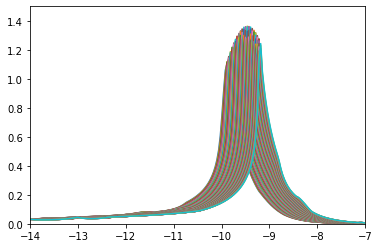

In [12]:
log10sSFR_grid = np.linspace(-14, -7, 200).astype(np.float32)
z_grid = np.linspace(0, 2.5, 100).astype(np.float32)

for z in z_grid:

    pdf = np.exp(NSF.log_prob(log10sSFR_grid, np.ones((log10sSFR_grid.shape[0], 1))*z).numpy())
    plt.plot(log10sSFR_grid, pdf)
plt.xlim(-14, -7)
plt.ylim(0, 1.5)
plt.show()

Log probability for prior matching calculation (MCMC)

In [96]:
def calculate_log10sSFR(theta):
    
    # convert to numpy
    theta = theta.numpy()
    
    # pull out the parameters
    log10alpha = theta[...,0]
    log10beta = theta[...,1]
    alpha = 10**theta[...,0]
    beta = 10**theta[...,1]
    tau = theta[...,2]
    z = theta[...,3]
    tuniv = tuniv_interpolator(z)
    
    # compute the log10sSFRs
    log10sSFR = compute_log10sSFR(alpha, beta, tau, z, tuniv)
    
    return log10sSFR

def log_probability(theta):
    
    # convert to numpy
    theta = theta.numpy()
    
    # pull out the parameters
    log10alpha = theta[...,0]
    log10beta = theta[...,1]
    alpha = 10**theta[...,0]
    beta = 10**theta[...,1]
    tau = theta[...,2]
    z = theta[...,3]
    tuniv = tuniv_interpolator(z)
    
    # compute the log10sSFRs
    log10sSFR = compute_log10sSFR(alpha, beta, tau, z, tuniv)
        
    # define target prior density
    mu_log10sSFR = (z <= 2.) * (2.1 * np.log10(1+z) - 10.) + (z > 2.) * (1.5 * np.log10(1+z) - 11. + np.log10(19.))
    sigma_log10sSFR = 0.3
    mu_log10sSFR_Q = -11.8
    sigma_log10sSFR_Q = 0.36
    log_target = np.log(np.exp(-0.5 * (log10sSFR - mu_log10sSFR)**2 / sigma_log10sSFR**2 - 0.5 * np.log(2*np.pi*sigma_log10sSFR**2)) + np.exp(-0.5 * (log10sSFR - mu_log10sSFR_Q)**2 / sigma_log10sSFR_Q**2 - 0.5 * np.log(2*np.pi*sigma_log10sSFR_Q**2)))
    
    # base parameter priors: tau, log10alpha, log10beta, log10sSFR
    log_prior = stats.uniform.logpdf(tau, loc=0.1, scale=tuniv-0.1) + stats.uniform.logpdf(log10alpha, loc=-1, scale=4) + stats.uniform.logpdf(log10beta, loc=-1, scale=4) + stats.uniform.logpdf(z, loc=0, scale=2.5) + stats.uniform.logpdf(log10sSFR, loc=-14, scale=7)
    
    # log baseline
    log_baseline = NSF.log_prob(tf.convert_to_tensor(log10sSFR, dtype=tf.float32), tf.convert_to_tensor(z, dtype=tf.float32)[...,tf.newaxis]).numpy()
    
    # total logprob
    logprob = tf.convert_to_tensor(log_prior + log_target - log_baseline, dtype=np.float32)
    
    return logprob

Initialize walkers

In [103]:
# prior samples
n_samples = 1000000
z = np.random.uniform(0, 2.5, n_samples)
tuniv = tuniv_interpolator(z)
alpha = 10**(np.random.uniform(-1, 3, n_samples))
beta = 10**(np.random.uniform(-1, 3, n_samples))
tau = np.random.uniform(0.1, tuniv)

# log10sSFRs
log10sSFR = compute_log10sSFR(alpha, beta, tau, z, tuniv)

cut = (log10sSFR > -11.) * (log10sSFR < -10.) * (np.isnan(log10sSFR) == False)
theta = tf.convert_to_tensor(np.column_stack([np.log10(alpha), np.log10(beta), tau, z])[cut,:], dtype=tf.float32)

# set-up
n_walkers = 5000
n_steps = 100 + 1000
n_params = 4
current_state = [theta[0:n_walkers,:], theta[n_walkers:2*n_walkers,:]]

<ipython-input-5-de9f1699defb>:2: RuntimeWarning: overflow encountered in power
  compute_log10sSFR = lambda alpha, beta, tau, z, tuniv: -np.log10((tuniv/tau)**alpha + (tau/tuniv)**beta) - np.log10((1./(beta+1.)) * tuniv*(tuniv/tau)**beta * hyp2f1(1., (beta+1.)/(alpha+beta), (beta+1.)/(alpha+beta) + 1., -(tuniv/tau)**(alpha+beta))) - 9. - np.log10(tf.squeeze(stellar_mass_emulator(tf.convert_to_tensor(np.column_stack([np.log10(alpha), np.log10(beta), tau, z]), dtype=tf.float32))).numpy())
<ipython-input-5-de9f1699defb>:2: RuntimeWarning: invalid value encountered in multiply
  compute_log10sSFR = lambda alpha, beta, tau, z, tuniv: -np.log10((tuniv/tau)**alpha + (tau/tuniv)**beta) - np.log10((1./(beta+1.)) * tuniv*(tuniv/tau)**beta * hyp2f1(1., (beta+1.)/(alpha+beta), (beta+1.)/(alpha+beta) + 1., -(tuniv/tau)**(alpha+beta))) - 9. - np.log10(tf.squeeze(stellar_mass_emulator(tf.convert_to_tensor(np.column_stack([np.log10(alpha), np.log10(beta), tau, z]), dtype=tf.float32))).numpy())
<ipyth

In [104]:
chain = affine_sample(log_probability, n_steps, current_state)

<ipython-input-5-de9f1699defb>:2: RuntimeWarning: overflow encountered in power
  compute_log10sSFR = lambda alpha, beta, tau, z, tuniv: -np.log10((tuniv/tau)**alpha + (tau/tuniv)**beta) - np.log10((1./(beta+1.)) * tuniv*(tuniv/tau)**beta * hyp2f1(1., (beta+1.)/(alpha+beta), (beta+1.)/(alpha+beta) + 1., -(tuniv/tau)**(alpha+beta))) - 9. - np.log10(tf.squeeze(stellar_mass_emulator(tf.convert_to_tensor(np.column_stack([np.log10(alpha), np.log10(beta), tau, z]), dtype=tf.float32))).numpy())
<ipython-input-5-de9f1699defb>:2: RuntimeWarning: invalid value encountered in power
  compute_log10sSFR = lambda alpha, beta, tau, z, tuniv: -np.log10((tuniv/tau)**alpha + (tau/tuniv)**beta) - np.log10((1./(beta+1.)) * tuniv*(tuniv/tau)**beta * hyp2f1(1., (beta+1.)/(alpha+beta), (beta+1.)/(alpha+beta) + 1., -(tuniv/tau)**(alpha+beta))) - 9. - np.log10(tf.squeeze(stellar_mass_emulator(tf.convert_to_tensor(np.column_stack([np.log10(alpha), np.log10(beta), tau, z]), dtype=tf.float32))).numpy())
<ipython-

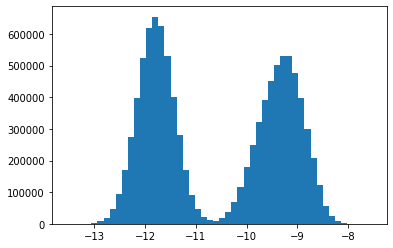

In [111]:
samples = tf.reshape(chain[100:,...], (-1,n_params))

plt.hist(calculate_log10sSFR(samples), bins = 50)
plt.show()

Generate parameters for training the emulator over

In [112]:
from scipy.stats import truncnorm
log10Z_mu = lambda log10M: -0.25933163 + 0.38391743*np.tanh(2.0229099*log10M - 20.37321787)
log10Z_sigma = lambda log10M: 0.6883885 - 0.37122853*np.tanh(2.47629773*log10M - 25.74109587)

In [114]:
n_batches = 64
n_samples = 100000

for batch in range(n_batches):
    
    # mass and metallicity
    log10M = np.random.uniform(7, 13, n_samples)
    mu = log10Z_mu(log10M)
    std = log10Z_sigma(log10M)
    log10Z = truncnorm.rvs(loc = mu, scale = std, a = (-1.98 - mu)/std, b = (0.5 - mu)/std)

    # dust
    dust2 = np.random.uniform(0, 2, n_samples)**2
    dust1_fraction = truncnorm.rvs(loc=1., scale=0.3, a=(0.-1.)/0.3, b=(2.-1.)/0.3, size=n_samples)

    # dust index
    mu = -0.095 + 0.111*dust2 - 0.0066*dust2**2
    scale = 0.4
    dust_index = truncnorm.rvs(loc=mu, scale=0.4, a=(-1-mu)/scale, b=(0.4-mu)/scale)

    # SFH and redshift
    SFH = samples[batch*n_samples:(batch+1)*n_samples, 0:3]
    z = samples[batch*n_samples:(batch+1)*n_samples, -1]
    
    parameters = np.column_stack([log10M, log10Z, dust2, dust1_fraction, dust_index, SFH[:,0], SFH[:,1], SFH[:,2], z])
    
    # save the parameters
    np.save('../model_B/training_data/parameters/parameters{}.npy'.format(batch), parameters)